[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Classification-Convolutional Kernels-1

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background 

CNNs are some of the most popular Artificial Neural Networks nowadays, and not without reason. In the computer vision domain, they have solved many problems and have advanced the technology a long way. Image classification, object detection, and many more tasks have become easier because of CNNs. 

Let's consider the term Convolutional Neural Network. CNNs have one operation at their core, convolution. 
Convolutions are the building-blocks of computer vision and image processing.

In its essence, an (image) convolution is simply an element-wise multiplication of two matrices followed by a sum. In simple terms:

1.  Take two matrices (which both have the same dimensions).
2.  Multiply them element-by-element.
3.  Sum the elements together.

In image convolutions, there are 2 important elements: an image, technically a "big" matrix, and a kernel, technically a "small" matrix. 
When applying convolution we slide the kernel along the image and apply the sum value of the convolutional operation on the pixel that corresponds
to the kernel's center. In other words, we scan the image with the kernel, replace the initial image's pixel values with the sum value, and this
produces a new image with different effects. The necessary steps are: 

1. Select an (x, y)-coordinate from the original image.
2. Place the center of the kernel at this (x, y)-coordinate.
3. Take the element-wise multiplication of the input image region and the kernel, then sum up the values of these multiplication operations into a single value. The sum of these multiplications is called the kernel output.
4. Store the sum value, kernel output, from the previous step on a new image on the same (x,y) coordinate.

To understand more about image convolutions and how they are applied in computer vision and image processing
keep reading this notebook.

### Library imports

In [1]:
%load_ext pycodestyle_magic
#%%pycodestyle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from glob import glob
from pathlib import Path
from skimage.exposure import rescale_intensity

### Auxiliar functions

In [2]:
def last_chars(file_name, num=4):
    '''
    Grabs the last <num> characters of a given file name

        Parameters:
            file_name (string) : The file_name to process
            num (int): Defines how many character from the end
                        of file_name to return

        Returns:
            last (string): The last <num> characters of the name
    '''
    last = file_name[-num:]
    return last

In [3]:
def read_data(path_list, im_size=(128, 128)):
    '''
    Sorts the file names (by their 4 last chars) and proceeds to load them.
    Resizes the images and appends them to a np.array X.

            Parameters:
                    path_list (list): List of paths to access
                    im_size (int tuple): Tuple of dimensions to resize to

            Returns:
                   X (np.array): Resized images
    '''
    X = []
    file_list = []  # auxiliary list

    # Append all desired file_paths to the auxiliary list
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')):
            file_list.append(im_file)

    # Sort the file names before reading them.
    for im_file in sorted(file_list, key=last_chars):
        if im_file.lower().endswith("jpg"):  # Disregard metadata & annotations
            try:
                im = cv2.imread(im_file)
                # Resize to appropriate dimensions.
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_LINEAR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                X.append(im)
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.

    return X

In [4]:
def plot_sample(X, title, rows, cols):
    '''
    Plots a list of images arranged ass an array of subplots.
    Length of X must be equal to rows * cols.
        Parameters:
              X (list) : List of images to plot
              title (string) : Title to print on top
              rows (int) : Number of rows of subplots
              cols (int) : Number of columns of subplots
    '''
    # Setting up figure parameters
    fig, axs = plt.subplots(rows, cols, figsize=(12, 12),
                            gridspec_kw={'wspace':0.002, 'hspace':0.002})
    
    # Define title's y-coordinate
    if (rows == 1): title_y = 0.65 
    elif (rows > 1): title_y = 0.9
        
    # Configuring title parameters
    plt.suptitle(title, verticalalignment='top', horizontalalignment='center', y=title_y, fontsize='x-large')

    index = 0
    for i in range(0, rows):
        for j in range(0, cols):
            if rows > 1:
                axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])
                axs[i][j].imshow(X[index], cmap='gray')
                index += 1
            elif rows == 1:
                axs[j].xaxis.set_ticklabels([])
                axs[j].yaxis.set_ticklabels([])
                axs[j].imshow(X[index], cmap='gray') 
                index += 1
           
    plt.show()        

### Convolution Function

We have already explained the convolution algorithm in the Background section of the notebook. 
Here is the code to implement it for both 1D (grayscale) and 3D (RGB) images.

This code is provided for educational purposes as there are already optimized functions available 
such as OpenCV's  cv2.filter2D .

In [5]:
def convolve(image, kernel):
    '''
    Apply convolution of a kernel and an image. Imitation-padding is used
    around the image to avoid decreasing the dimensions of the convolved image.
    The intensity of the convolved image is rescaled and converted to integer.

            Parameters:
                    image (np.array): Image to convolve
                    kernel (np.array): Kernel that produces the desired effect

            Returns:
                    convoluted (np.array): Contains the convolution's result
    '''
    iW, iH = image.shape[0:2]
    kW, kH = kernel.shape[0:2]
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)

    # Decide whether image is RGB or Grayscale
    if (len(image.shape) == 3):
        rgb = True
        channels = 3
    else:
        rgb = False

    # Convolution operation
    if(rgb):
        convoluted = np.zeros((iH, iW, image.shape[2]), dtype='float32')
        for channel in range(0, image.shape[2]):
            for y in range(pad, iH + pad):
                for x in range(pad, iW + pad):
                    # Region of Interest
                    roi = image[y - pad: y + pad + 1,
                                x - pad: x + pad + 1,
                                channel]
                    dot_sum = (roi * kernel).sum()  # Sum of the dot product
                    convoluted[y - pad, x - pad, channel] = dot_sum
    # For grayscale images
    else:
        convoluted = np.zeros((iH, iW), dtype='float32')
        for y in range(pad, iH + pad):
            for x in range(pad, iW + pad):
                # Region of Interest
                roi = image[y - pad: y + pad + 1,
                            x - pad: x + pad + 1]
                dot_sum = (roi * kernel).sum()  # Sum of the dot product
                convoluted[y - pad, x - pad] = dot_sum

    # Normalize values in range [0,255] and convert to type uint8
    convoluted = rescale_intensity(convoluted, in_range=(0, 255))
    convoluted = (convoluted * 255).astype("uint8")

    return convoluted

### Loading and reading data from the dataset folder

In [6]:
# Path to the desired dataset.
DATASETS = ['Pear tree-290920-Stephanitis pyri-zz-V1-20210225103248']
IM_SIZE = (256, 256)  # Dimensions to resize to.
path_list = []

for i, path in enumerate(DATASETS):
    # Define paths in an OS agnostic way.
    path_list.append(str(Path(Path.cwd()).parents[0]
                         .joinpath('eden_data').joinpath(path)))

X = read_data(path_list, IM_SIZE)

100%|██████████| 31/31 [00:00<00:00, 518021.61it/s]


In [7]:
# Use random image as input
image = X[11]

# Convert original image to Grayscale
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Convolutional Kernel definitions

These kernels are well known in literature and have been used for many years to provide different effects.

#### Sharpen & Blur

In [8]:
# Kernel for applying sharpening filter.
sharpen = np.array([[-1, -1, -1],
                    [-1,  9, -1],
                    [-1, -1, -1]])

# Kernel for applying Gaussian blur.
gauss_blur = (1 / 16) * np.array([[1, 2, 1],
                                  [2, 4, 2],
                                  [1, 2, 1]])

# Kernel for applying mean blur.
# Creates pixel values derived from the mean value of the kernel's neighbourhood
mean = (1 / 9) * np.array([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])

#### Edge Detection

In [9]:
# Kernel for Edge detection.
edge_det = np.array([[-1, -1, -1],
                     [-1,  8, -1],
                     [-1, -1, -1]])

# Laplacian kernel used for gradient calculation and edge detection.
# Combine with Gaussian blur to create Laplacian of Gaussian (LoG).
laplacian = np.array([[ 0, -1,  0],
                      [-1,  4, -1],
                      [ 0, -1,  0]])

#### Sobel Operators

Combining both Sobel operators produces the gradient magnitude/edge detection.

In [10]:
# Sobel operator kernel for vertical edge detection
sobel_v = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

# Sobel operator kernel for horizontal edge detection
sobel_h = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

#### Line Detection

In [11]:
# Vertical line detection kernel
line_det_v = np.array([[-1, 2, -1],
                       [-1, 2, -1],
                       [-1, 2, -1]])

# Horizontal line detection kernel
line_det_h = np.array([[-1, -1, -1],
                       [ 2,  2,  2],
                       [-1, -1, -1]])

### Convolutional Kernel application on images

We will start convoluting using kernels to produce some interesting effects.<br>
**Blurring and Sharpening** are effects that we often use in many photo editing apps. As you will see, they are nothing more than convolutions.
1. Gaussian blur kernel
2. Mean kernel
3. Sharpen effect kernel

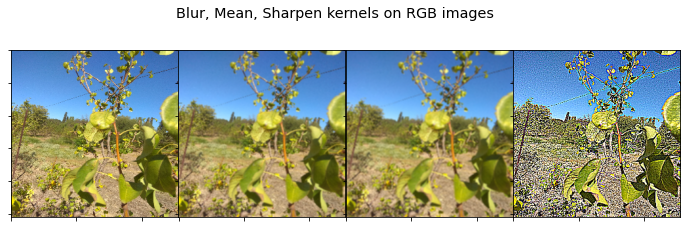

In [12]:
blur1_rgb = convolve(image, gauss_blur)
blur2_rgb = convolve(image, mean)
sharp_rgb = convolve(image, sharpen)

images_rgb = [image, blur1_rgb, blur2_rgb, sharp_rgb]
plot_sample(images_rgb, "Blur, Mean, Sharpen kernels on RGB images", 1, 4)

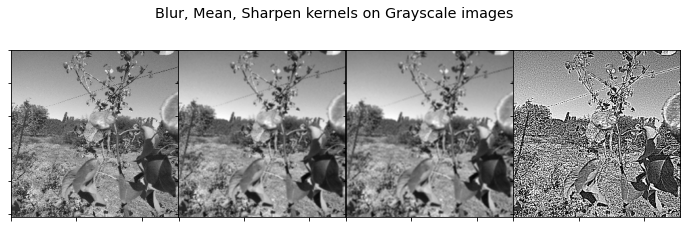

In [13]:
blur1_bw = convolve(image_bw, gauss_blur)
blur2_bw = convolve(image_bw, mean)
sharp_bw = convolve(image_bw, sharpen)

images_bw = [image_bw, blur1_bw, blur2_bw, sharp_bw]
plot_sample(images_bw, "Blur, Mean, Sharpen kernels on Grayscale images", 1, 4)

**Edge detection** is also a very crucial part of computer vision and is incorporated in a myriad of applications. We have previously defined kernels that can be used to detect edges in images:
1.  Edge detection kernel
2.  Laplacian kernel

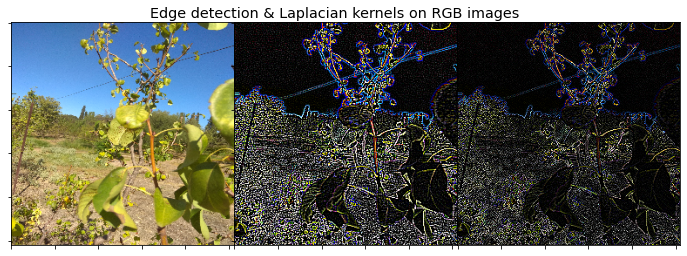

In [14]:
edge_detected_rgb = convolve(image, edge_det)
laplacian_rgb = convolve(image, laplacian)

images_rgb = [image, edge_detected_rgb, laplacian_rgb]
plot_sample(images_rgb, "Edge detection & Laplacian kernels on RGB images", 1, 3)

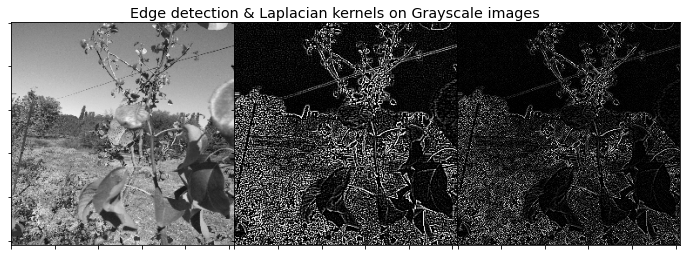

In [15]:
edge_detected_bw = convolve(image_bw, edge_det)
laplacian_bw = convolve(image_bw, laplacian)

images_bw = [image_bw, edge_detected_bw, laplacian_bw]
plot_sample(images_bw, "Edge detection & Laplacian kernels on Grayscale images", 1, 3)

### Sobel operators 
The Sobel operator performs a 2-D spatial gradient measurement on an image and so emphasizes regions of high spatial frequency that correspond to edges. Typically it is used to find the approximate absolute gradient magnitude at each point in a grayscale image. Here we will try it on RGB images as well.

First, we convolute with the vertical operator which mostly detects vertical gradient changes. Then we convolute with the horizontal operator which detects horizontal gradient changes. Finally, we merge the previous results to create a fully edge-detected image.

In our example image, the background has a lot of information (noise) which is captured by the Sobel operators (background edges). Consequently, the resulting image is not very clear, but you can verify that the edges on the object of interest have been detected correctly.

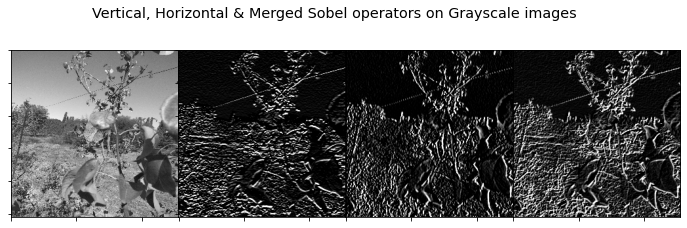

In [16]:
sob_bw_v = convolve(image_bw, sobel_v)  # vertical Sobel
sob_bw_h = convolve(image_bw, sobel_h)  # vertical Sobel

# Merge vertical and horizontal sober operators
sobel_bw = cv2.addWeighted(sob_bw_v, 0.8, sob_bw_h, 0.8, 0.0)

images_bw = [image_bw, sob_bw_v, sob_bw_h, sobel_bw]
plot_sample(images_bw, "Vertical, Horizontal & Merged Sobel operators on Grayscale images", 1, 4)

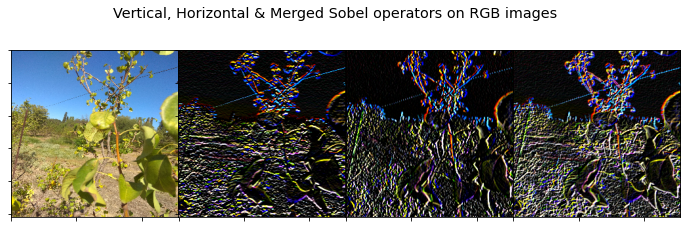

In [17]:
sob_rgb_v = convolve(image, sobel_v)  # vertical Sobel
sob_rgb_h = convolve(image, sobel_h)  # vertical Sobel

# Merge vertical and horizontal sober operators
sobel_rgb = cv2.addWeighted(sob_rgb_v, 0.8, sob_rgb_h, 0.8, 0.0)

images_rgb = [image, sob_rgb_v, sob_rgb_h, sobel_rgb]
plot_sample(images_rgb, "Vertical, Horizontal & Merged Sobel operators on RGB images", 1, 4)

### Splitting an image in each respective color channels and processing those.
CNNs will take an RGB image and split it into its 3 color channels converting it from a single 3D-array to three 2D-arrays. Afterwards, convolutions are applied upon those
channels, and the network tries to detect features in each respective channel in order to make decisions. 

Now we shall immitate the work of a neural network: we will first split the image into its 3 color channels and then detect edges using convolutional kernels. We will do this by applying 3 different kernels:
1.  Edge detection kernel
2.  Laplacian kernel
3.  Laplacian of Gaussian (LoG)

In [18]:
# Split image's 3 color channels into 2D-arrays.
image_r = image[:, :, 0]
image_g = image[:, :, 1]
image_b = image[:, :, 2]

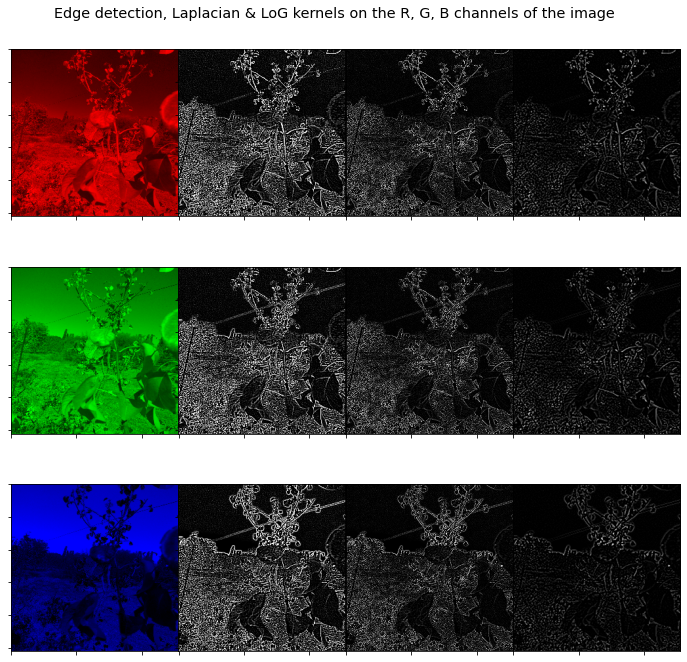

In [19]:
# Convolution kernels on the red channel
edge_detect_r = convolve(image_r, edge_det)
laplacian_r = convolve(image_r, laplacian)
blur_r = convolve(image_r, gauss_blur)
log_r = convolve(blur_r, laplacian)

# Convolution kernels on the green channel
edge_detect_g = convolve(image_g, edge_det)
laplacian_g = convolve(image_g, laplacian)
blur_g = convolve(image_g, gauss_blur)
log_g = convolve(blur_g, laplacian)

# Convolution kernels on the blue channel
edge_detect_b = convolve(image_b, edge_det)
laplacian_b = convolve(image_b, laplacian)
blur_b = convolve(image_b, gauss_blur)
log_b = convolve(blur_b, laplacian)

dim = np.zeros_like(image[:, :, 0])

image_m_r = cv2.merge([image_r, dim, dim])
image_m_g = cv2.merge([dim, image_g, dim])
image_m_b = cv2.merge([dim, dim, image_b])

images = [image_m_r, edge_detect_r, laplacian_r, log_r,
          image_m_g, edge_detect_g, laplacian_g, log_g,
          image_m_b, edge_detect_b, laplacian_b, log_b]
plot_sample(images, "Edge detection, Laplacian & LoG kernels on the R, G, B channels of the image", 3, 4)

### Line detection
Besides edges, a very common basic feature worth detecting is lines. Line detection is essential in detecting higher-level features such as shapes.

The following convolution kernels highlight lines in the images. Our sample image may not contain clear horizontal or vertical lines, but you shall see how easily you can detect lines using convolutions.

Even though the results may resemble edge detection, they are not; these kernels only detect straight lines.

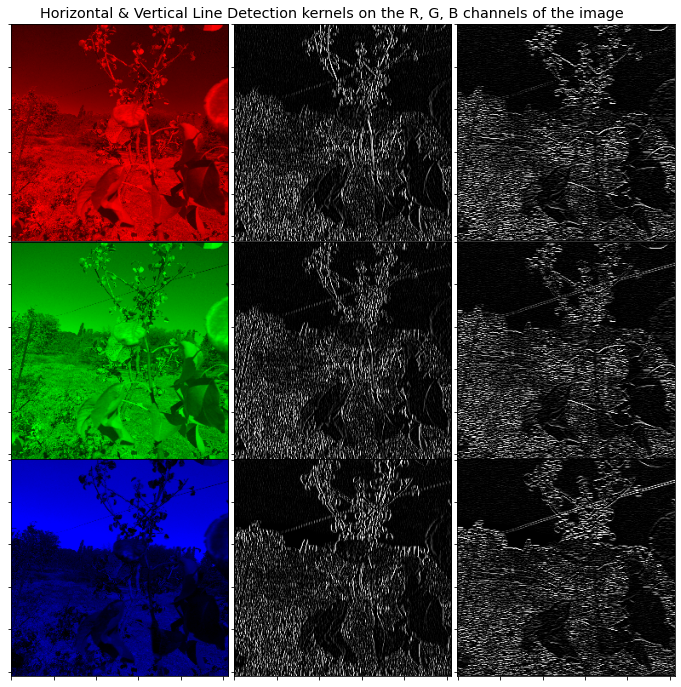

In [20]:
# Line detection on the red channel
lines_v_r = convolve(image_r, line_det_v)
lines_h_r = convolve(image_r, line_det_h)

# Line detection on the green channel
lines_v_g = convolve(image_g, line_det_v)
lines_h_g = convolve(image_g, line_det_h)

# Line detection on the blue channel
lines_v_b = convolve(image_b, line_det_v)
lines_h_b = convolve(image_b, line_det_h)

images = [image_m_r, lines_v_r, lines_h_r,
          image_m_g, lines_v_g, lines_h_g,
          image_m_b, lines_v_b, lines_h_b]
plot_sample(images, "Horizontal & Vertical Line Detection kernels on the R, G, B channels of the image", 3, 3)

## Conclusions

We can conclude that convolutions are a very powerful and useful tool in computer vision and image processing. It can be used to provide different imaging effects but also to detect certain features. As we presented, edge/line detection is very easy to achieve with few lines of code thanks to convolutions. Edges and lines are the most basic features we can detect in an image. More complicated combinations of kernels will be able to detect more complicated features such as a leaf, an apple, or a leaf disease.

Convolutional kernels are the backbone of CNNs. However, the magic of deep learning is in that the kernels are automatically selected through training to detect the desired features. Therefore, a solid understanding of how convolutions work is essential to understanding deep learning and CNNs better.

## Possible Extensions
1. Experiment with the kernel values, modify them and observe results.
2. Try different resize factors while reading images.
3. Apply different kernels on the split channel images.
4. Apply the kernels on a different [Eden Library dataset](https://edenlibrary.ai/datasets).

## Bibliography

Wikipedia article about [kernels in image processing](https://en.wikipedia.org/wiki/Kernel_(image_processing)) with many useful kernels

Article on [line detection through kernels](https://kharshit.github.io/blog/2018/12/14/filters-in-convolutional-neural-networks)

https://setosa.io/ev/image-kernels/ : A great interactive site to underastand how kernels work and experiment with them.

[Sobel Operator](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm)

https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/

https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37